# Dataset and Model Download Links

[Download Dataset](https://drive.google.com/drive/folders/18KbGZbWo9fFeMj9JBIaSqU6szBKxXTUR?usp=sharing)

[Model for Predicting Activity Change by 2 Hours](https://drive.google.com/file/d/17GFe94EVVTUQY9nuzELx2k--ic9jNmly/view?usp=sharing)

[Model for predicting Activity Change](https://drive.google.com/file/d/1-AD4mq1dgUDZKnZIP0MXDhOsfPfCa3_Q/view?usp=sharing)

[Model for predicting if Activity Change is above a value](https://drive.google.com/file/d/1Qswy_MwIe9_5RobSkBLzUMNRl2GGMrcU/view?usp=sharing)

**The model for predicting the 'Activity Change' is dependent on the output of values predicted of 'Activity Change by 2 Hours' .**


 **Insert relevant paths for dataset folder and model**

# Model Testing for 32 Cattle dataset

## Loading Libraries

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
from sklearn.preprocessing import StandardScaler

from keras import models
from keras import layers
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 

import os
import glob

from sklearn import metrics

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

In [166]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [167]:
!pip install --upgrade xlrd

## Defining Functions

In [168]:
def data_preprocess(data):

    data = data.reindex(index=data.index[::-1])
    data['Date_Time'].min(), data['Date_Time'].max()
    data.dropna(inplace = True)
    data = data.set_index('Date_Time')

    return data

In [169]:
def create_features(data):

    data['6_hrs_prior_mean'] = (data['Raw Activity Data'].rolling(window=3).mean()).round(2)

    data['x_minus_total_mean'] = data['Raw Activity Data']-(data['Raw Activity Data'].mean())
    
    days_lag = [1,2,3,4,5,6,7]
    for i in days_lag:
        data[f'{i}_day_lag'] = data['Raw Activity Data']
        data[f'{i}_day_lag'] = data[f'{i}_day_lag'].shift(12*i, axis = 0)
    
    data.dropna(inplace = True)
    
    data['x_minus_6_hrs_prior_mean'] = data['Raw Activity Data'] - data['6_hrs_prior_mean']
    
    data1 = data.copy()
    data1 = data1.reset_index()
    unique_cows=sorted(data1['Cow Number'].unique())
    test_data = pd.DataFrame()

    for i in unique_cows:
        a = data1.loc[data1['Cow Number'] == i]
        a = a.tail(100)
        test_data = pd.concat((test_data,a), axis = 0)
        data1.drop(data1.loc[data1['Cow Number'] == i].index, inplace=True)

    test_data = test_data.set_index('Date_Time')
    train_data = (data[~data.index.isin(test_data.index)])

    train_data = train_data.drop('Cow Number', axis = 1)
    test_data = test_data.drop('Cow Number', axis = 1)
    return data, test_data, train_data

In [170]:
def correlation(data):

    corr = data.corr()

    # corr
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 15))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax = 1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

In [171]:
def load_data(path):
    csv_files = glob.glob(os.path.join(path, "*.xls"))
  
    data = pd.DataFrame()

    # loop over the list of csv files
    for f in csv_files:

        # read the csv file
        df = pd.read_excel(f, parse_dates=[['Date', 'Time']])
        df = df.reindex(index=df.index[::-1])
        data = pd.concat((data, df),axis = 0)

    data = data.drop(['Unnamed: 0'], axis = 1)
    data.dropna(inplace = True)
    data = data.set_index('Date_Time')  
    return data

In [172]:
def pre_process_for_predicting_activity(data):

    # lags for predicted activity change by 2 hours
    lags = [2,4,6,8]

    for i in lags:
        data['2_hr_lag_predicted'] = data['Predicted_Activity Change by 2 Hours']
        data['2_hr_lag_predicted'] = data['2_hr_lag_predicted'].shift(1, axis = 0)

        data['4_hr_lag_predicted'] = data['Predicted_Activity Change by 2 Hours']
        data['4_hr_lag_predicted'] = data['4_hr_lag_predicted'].shift(2, axis = 0)

        data['6_hr_lag_predicted'] = data['Predicted_Activity Change by 2 Hours']
        data['6_hr_lag_predicted'] = data['6_hr_lag_predicted'].shift(3, axis = 0)

        data['8_hr_lag_predicted'] = data['Predicted_Activity Change by 2 Hours']
        data['8_hr_lag_predicted'] = data['8_hr_lag_predicted'].shift(4, axis = 0)

    
    data.dropna(inplace = True)

    return data 

In [173]:
def standard_scaler(data, custom_columns=0):
    if custom_columns==0:
        data_col_names = data.columns
    else:
        data_col_names = custom_columns

    features_data = data[data_col_names]
    scaler = StandardScaler().fit(features_data)
    features_data = scaler.transform(features_data.values)
    data[data_col_names] = features_data

    return data, scaler

In [174]:
def evaluation_metrics_inverse_transform(x_data, y_data, scaler, target_variable):
    predicted_vals = pd.DataFrame(data = saved_model.predict(x_data), index = x_data.index, columns = [f'Predicted_{target_variable}'])

    print('MAE:',metrics.mean_absolute_error(y_data[target_variable],predicted_vals).round(4))
    print('MSE',metrics.mean_squared_error(y_data[target_variable],predicted_vals, squared=False).round(4))
    print('Correlation:', (y_data[target_variable].corr(predicted_vals[f'Predicted_{target_variable}'])).round(4))

    predicted_vals[f'Predicted_{target_variable}'] = scaler.inverse_transform(pd.DataFrame(predicted_vals))
    return predicted_vals

In [175]:
def print_graphs_for_cow_activity(x_data, y_data, saved_model, data_scaler, target_variable):
    x_test0 = x_data.reset_index()
    y_test0 = y_data.reset_index()

    cows = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
    xtest_sets = []
    ytest_sets = []
    a = 0
    b = 99
    for i in range(len(cows)):

        x_test1 = x_test0.loc[a:b]
        y_test1 = y_test0.loc[a:b]

        a = a+100
        b = b+100

        x_test1 = x_test1.set_index('Date_Time')
        y_test1 = y_test1.set_index('Date_Time')

        xtest_sets.append(x_test1)
        ytest_sets.append(y_test1)


    cows = ['Cow1', 'Cow2', 'Cow3','Cow4', 'Cow5', 'Cow6','Cow7', 'Cow8', 'Cow9','Cow10', 'Cow11', 'Cow12','Cow13', 'Cow14', 'Cow15','Cow16', 'Cow17', 'Cow18','Cow19', 'Cow20', 'Cow21','Cow22', 'Cow23', 'Cow24','Cow25', 'Cow26', 'Cow27','Cow28', 'Cow29', 'Cow30','Cow31', 'Cow32']
    for i in range(len(xtest_sets)):
        predicted = pd.DataFrame(data=saved_model.predict(xtest_sets[i]), index = xtest_sets[i].index)
        predicted = predicted.rename({0:f'Predicted_{target_variable}_{cows[i]}'}, axis = 1)
        predicted[f'{target_variable}'] = ytest_sets[i][f'{target_variable}']
        predicted[f'Predicted_{target_variable}_{cows[i]}'] = data_scaler.inverse_transform(pd.DataFrame(predicted[f'Predicted_{target_variable}_{cows[i]}']))
        predicted[f'{target_variable}'] = data_scaler.inverse_transform(pd.DataFrame(predicted[f'{target_variable}']))

        print('-*-'*40)
        print(cows[i])
        print('MAE:',metrics.mean_absolute_error(predicted[f'{target_variable}'],predicted[f'Predicted_{target_variable}_{cows[i]}']).round(2))
        print('MSE',metrics.mean_squared_error(predicted[f'{target_variable}'],predicted[f'Predicted_{target_variable}_{cows[i]}'], squared=False).round(2))
        print('Correlation:', (predicted[f'{target_variable}'].corr(predicted[f'Predicted_{target_variable}_{cows[i]}'])).round(4))
        plot1 = predicted.plot(y = [f'{target_variable}',f'Predicted_{target_variable}_{cows[i]}'],figsize = (16,8))
        plt.show()
        print('-*-'*40)

In [176]:
def accuracy_metrics(y_pred, y_test):

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_pred, y_test)
    print('Accuracy: %f ' % (accuracy*100))

    # precision tp / (tp + fp)
    precision = precision_score(y_pred, y_test, average = 'macro')
    print('\nPrecision: %f ' % (precision*100))

    # recall: tp / (tp + fn)
    recall = recall_score(y_pred, y_test, average = 'macro')
    print('\nRecall: %f' % (recall*100))

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_pred, y_test, average = 'macro')
    print('\nF1 score: %f' % (f1*100))
    
    # kappa
    kappa = cohen_kappa_score(y_pred, y_test)
    print('\nCohens kappa: %f\n' % kappa)

    # ROC AUC
    # auc = roc_auc_score(y_pred, y_test,average = 'macro', multi_class = 'ovo',)
    # print('\nROC AUC: %f\n' % auc)

    # confusion matrix
    matrix = confusion_matrix(y_pred, y_test)
    print(matrix)

In [177]:
def testing_values_for_threshold(data, threshold):
    data['Activity_Change_Binned'] = ''
    for i in range(len(data)):
        if data['Predicted_Activity Change'][i] >=threshold:
            data['Activity_Change_Binned'][i] = 1
        else:
            data['Activity_Change_Binned'][i] = 0
    print(data['Activity_Change_Binned'].value_counts())
    data['Activity_Change_Binned'].value_counts().plot(kind='bar')

In [178]:
def make_binned_columns_by_setting_threshold(data,threshold):
    data['Activity_Change_Binned'] = ''
    for i in range(len(data)):
        if data['Predicted_Activity Change'][i] >=threshold:
            data['Activity_Change_Binned'][i] = 1
        else:
            data['Activity_Change_Binned'][i] = 0
    return data

In [179]:
def create_bins(data, old_column_names, new_column_names, drop_old_column, bins, labels):
    bins_items = list(bins.values())[0]
    labels_items = list(labels.values())[0]

    for i in range(len(old_column_names)):
        bins_items = list(bins.values())[i]
        labels_items = list(labels.values())[i]
        data[new_column_names[i]] = pd.cut(data[old_column_names[i]], bins = bins_items, labels = labels_items)
    if drop_old_column == 'yes':
        data=data.drop(old_column_names, axis = 1)
    else:
        pass
    # data[new_column_names] = data[new_column_names].astype('int')
    return data

## Loading Data and Data Preparation 

In [322]:
# get data file names
path ='/content/drive/MyDrive/Jio-Time_Series/Raw_Activity_till_28_10_2021'
data = load_data(path)

In [323]:
data.head()

,Cow Number,Raw Activity Data,Activity Change by 2 Hours,Activity Change
Date_Time,,,,
2021-07-30 00:00:00,1,28.0,-3.379431,0.0
2021-07-30 02:00:00,1,29.0,-2.917902,-1.0
2021-07-30 04:00:00,1,31.0,-3.004626,-3.0
2021-07-30 06:00:00,1,33.0,2.578553,-2.0
2021-07-30 08:00:00,1,26.0,-13.242444,-8.0


In [324]:
data, test_data, train_data = create_features(data)

In [325]:
train_data.head()

,Raw Activity Data,Activity Change by 2 Hours,Activity Change,6_hrs_prior_mean,x_minus_total_mean,1_day_lag,2_day_lag,3_day_lag,4_day_lag,5_day_lag,6_day_lag,7_day_lag,x_minus_6_hrs_prior_mean
Date_Time,,,,,,,,,,,,,
2021-08-21 14:00:00,27.0,-4.081197,5.0,30.00,-5.115485,26.0,34.0,29.0,38.0,41.0,45.0,28.0,-3.00
2021-08-21 16:00:00,30.0,-5.893336,4.0,28.33,-2.115485,30.0,31.0,34.0,43.0,43.0,27.0,29.0,1.67
2021-08-21 18:00:00,34.0,-14.387335,-7.0,30.33,1.884515,41.0,43.0,51.0,48.0,49.0,32.0,31.0,3.67
2021-08-21 20:00:00,45.0,-7.594741,-16.0,36.33,12.884515,50.0,49.0,53.0,53.0,44.0,35.0,33.0,8.67
2021-08-21 22:00:00,36.0,-1.402245,-18.0,38.33,3.884515,40.0,53.0,38.0,29.0,35.0,30.0,26.0,-2.33


In [326]:
data.shape, test_data.shape, train_data.shape

((27478, 14), (3200, 13), (24278, 13))

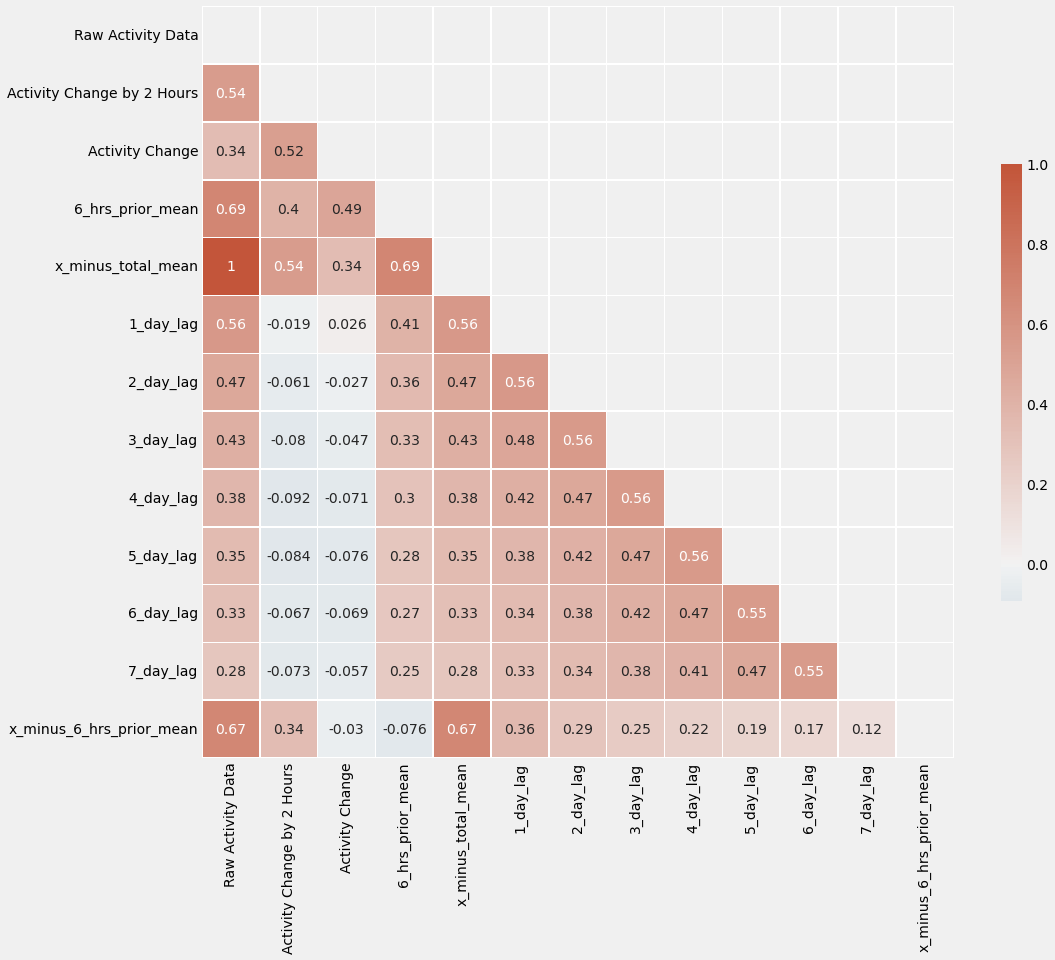

In [327]:
correlation(train_data)

### Splitting training and testing data

In [328]:
x_train = train_data.drop(['Activity Change by 2 Hours', ], axis = 1)
y_train = pd.DataFrame(train_data[['Activity Change by 2 Hours']])

x_test = test_data.drop(['Activity Change by 2 Hours', ], axis = 1)
y_test = pd.DataFrame(test_data[['Activity Change by 2 Hours']])

# x_train['Cow Number'] = x_train['Cow Number'].astype('category')
# x_test['Cow Number'] = x_test['Cow Number'].astype('category')

In [329]:
column_names = ['Raw Activity Data','6_hrs_prior_mean','x_minus_total_mean','1_day_lag','2_day_lag','3_day_lag','4_day_lag','5_day_lag','6_day_lag','7_day_lag','x_minus_6_hrs_prior_mean']
x_train, scaler = standard_scaler(x_train, column_names)

features_test = x_test[column_names]
features_test = scaler.transform(features_test.values)
x_test[column_names] = features_test

# saving the scaler for X values
pk.dump(scaler,open('/content/drive/MyDrive/Jio-Time_Series/x_values_scaler.pk','wb'))

In [330]:
y_train, target_scaler = standard_scaler(y_train)

y_test_columns = y_test.columns
features_ytest = y_test[y_test_columns]
features_ytest = target_scaler.transform(features_ytest.values)
y_test[y_test_columns] = features_ytest

pk.dump(target_scaler,open('/content/drive/MyDrive/Jio-Time_Series/y_values_scaler.pk','wb'))

In [331]:
x_train_less_activity = x_train.drop('Activity Change',axis=1)
x_test_less_activity = x_test.drop('Activity Change',axis=1)

## Testing the model built for "Activity Change by 2 Hours"

In [332]:
saved_model = models.load_model('/content/drive/MyDrive/Jio-Time_Series/Activity_Change_by_2_Hours.h5')
# saved_model = models.load_model('https://drive.google.com/file/d/17GFe94EVVTUQY9nuzELx2k--ic9jNmly/view?usp=sharing')

In [333]:
predicted_vals_train = evaluation_metrics_inverse_transform(x_train_less_activity, y_train, target_scaler, 'Activity Change by 2 Hours')

MAE: 0.3021
MSE 0.5088
Correlation: 0.8725


In [334]:
predicted_vals_test = evaluation_metrics_inverse_transform(x_test_less_activity, y_test, target_scaler, 'Activity Change by 2 Hours')

MAE: 0.2171
MSE 0.4321
Correlation: 0.9446


In [335]:
print_graphs_for_cow_activity(x_test_less_activity, y_test, saved_model, target_scaler, 'Activity Change by 2 Hours')

Output hidden; open in https://colab.research.google.com to view.

## Data Preparation for predicting "Activity Change"

In [336]:
x_train = train_data.drop(['Activity Change by 2 Hours', '1_day_lag','2_day_lag','3_day_lag','4_day_lag','5_day_lag','6_day_lag','7_day_lag','6_hrs_prior_mean','x_minus_total_mean','x_minus_6_hrs_prior_mean'], axis = 1)
x_test = test_data.drop(['Activity Change by 2 Hours', '1_day_lag','2_day_lag','3_day_lag','4_day_lag','5_day_lag','6_day_lag','7_day_lag','6_hrs_prior_mean','x_minus_total_mean','x_minus_6_hrs_prior_mean'], axis = 1)

predicted_vals_train = pd.concat((predicted_vals_train, x_train), axis = 1)
predicted_vals_test = pd.concat((predicted_vals_test, x_test), axis = 1)

In [337]:
predicted_vals_train

,Predicted_Activity Change by 2 Hours,Raw Activity Data,Activity Change
Date_Time,,,
2021-08-21 14:00:00,-2.954815,27.0,5.0
2021-08-21 16:00:00,-3.385047,30.0,4.0
2021-08-21 18:00:00,-6.768668,34.0,-7.0
2021-08-21 20:00:00,-3.190730,45.0,-16.0
2021-08-21 22:00:00,-0.352340,36.0,-18.0
...,...,...,...
2021-10-20 02:00:00,-1.875175,23.0,-2.0
2021-10-20 04:00:00,-4.712996,23.0,-3.0
2021-10-20 06:00:00,6.984033,33.0,-1.0


In [338]:
predicted_vals_train = pre_process_for_predicting_activity(predicted_vals_train)
predicted_vals_test = pre_process_for_predicting_activity(predicted_vals_test)

In [339]:
predicted_vals_train.head()

,Predicted_Activity Change by 2 Hours,Raw Activity Data,Activity Change,2_hr_lag_predicted,4_hr_lag_predicted,6_hr_lag_predicted,8_hr_lag_predicted
Date_Time,,,,,,,
2021-08-21 22:00:00,-0.352340,36.0,-18.0,-3.190730,-6.768668,-3.385047,-2.954815
2021-08-22 00:00:00,0.528902,42.0,-9.0,-0.352340,-3.190730,-6.768668,-3.385047
2021-08-22 02:00:00,4.667809,31.0,-5.0,0.528902,-0.352340,-3.190730,-6.768668
2021-08-22 04:00:00,-2.849646,28.0,-4.0,4.667809,0.528902,-0.352340,-3.190730
2021-08-22 06:00:00,-2.255928,30.0,-4.0,-2.849646,4.667809,0.528902,-0.352340


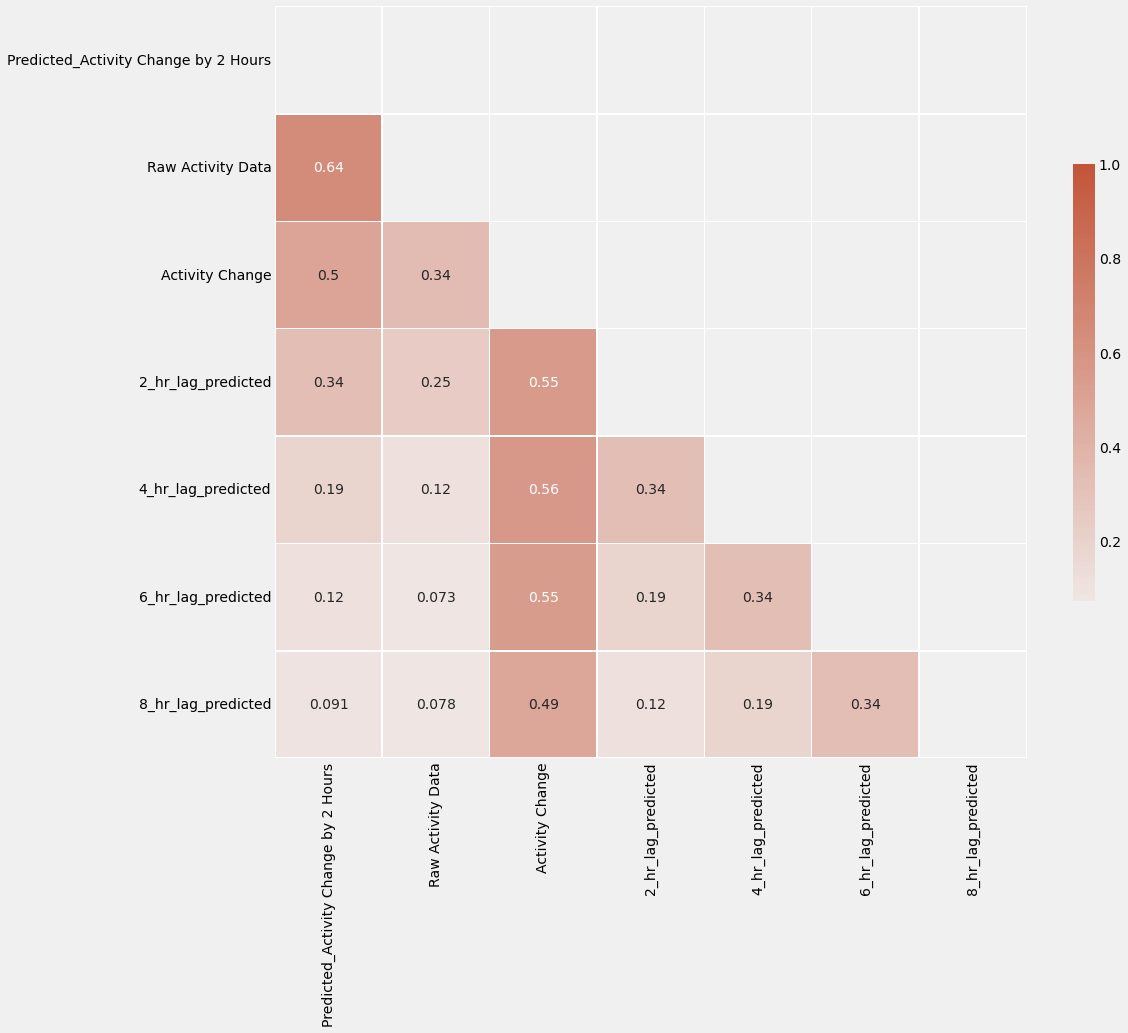

In [340]:
correlation(predicted_vals_train)

In [341]:
x_train_for_activity_change = pd.DataFrame(predicted_vals_train.drop('Activity Change', axis = 1))
x_test_for_activity_change = pd.DataFrame(predicted_vals_test.drop('Activity Change', axis = 1))

y_train_for_activity_change = pd.DataFrame(predicted_vals_train['Activity Change'])
y_test_for_activity_change = pd.DataFrame(predicted_vals_test['Activity Change'])

In [342]:
y_train_for_activity_change, target_scaler_for_activity_change = standard_scaler(y_train_for_activity_change)

col_names_ytest_for_activity_change = y_test_for_activity_change.columns
features_ytest_for_activity_change = y_test_for_activity_change[col_names_ytest_for_activity_change]

features_ytest_for_activity_change = y_test_for_activity_change[col_names_ytest_for_activity_change]
features_ytest_for_activity_change = target_scaler_for_activity_change.transform(features_ytest_for_activity_change.values)
y_test_for_activity_change[col_names_ytest_for_activity_change] = features_ytest_for_activity_change

pk.dump(target_scaler_for_activity_change,open('/content/drive/MyDrive/Jio-Time_Series/y_values_scaler_activity_change.pk','wb'))

In [343]:
x_train_for_activity_change, scaler_for_activity_change = standard_scaler(x_train_for_activity_change)

col_names_xtest_for_activity_change = x_test_for_activity_change.columns
features_xtest_for_activity_change = x_test_for_activity_change[col_names_xtest_for_activity_change]

features_xtest_for_activity_change = scaler_for_activity_change.transform(features_xtest_for_activity_change.values)
x_test_for_activity_change[col_names_xtest_for_activity_change] = features_xtest_for_activity_change

pk.dump(scaler_for_activity_change,open('/content/drive/MyDrive/Jio-Time_Series/x_values_scaler_activity_change.pk','wb'))

## Testing the model built for "Activity Change"

In [344]:
saved_model = models.load_model('/content/drive/MyDrive/Jio-Time_Series/Activity_Change.h5')

In [345]:
predicted_vals_train = evaluation_metrics_inverse_transform(x_train_for_activity_change, y_train_for_activity_change, target_scaler_for_activity_change, 'Activity Change')

MAE: 0.3494
MSE 0.5104
Correlation: 0.8614


In [346]:
predicted_vals_test = evaluation_metrics_inverse_transform(x_test_for_activity_change, y_test_for_activity_change, target_scaler_for_activity_change, 'Activity Change')

MAE: 0.3146
MSE 0.4994
Correlation: 0.8785


In [347]:
print_graphs_for_cow_activity(x_test_for_activity_change, y_test_for_activity_change, saved_model, target_scaler_for_activity_change, 'Activity Change')

Output hidden; open in https://colab.research.google.com to view.

## Data Preparation for Binned Activity Change

In [348]:
x_train_for_activity_change[x_train_for_activity_change.columns] = scaler_for_activity_change.inverse_transform(x_train_for_activity_change[x_train_for_activity_change.columns].values)
x_test_for_activity_change[x_test_for_activity_change.columns] = scaler_for_activity_change.inverse_transform(x_test_for_activity_change[x_train_for_activity_change.columns].values)

In [349]:
train_data_for_binned_activity = pd.concat((x_train_for_activity_change, predicted_vals_train), axis = 1)
test_data_for_binned_activity = pd.concat((x_test_for_activity_change, predicted_vals_test), axis = 1)

In [350]:
old_column_names = ['Predicted_Activity Change']
new_column_names = ['Activity_Change_Binned']
drop_old_column = 'yes'
bins = {"1":[min(train_data_for_binned_activity['Predicted_Activity Change']),0,10,20,max(train_data_for_binned_activity['Predicted_Activity Change'])]}
labels = {"1":[0,1,2,3]}
train_data_for_binned_activity = create_bins(train_data_for_binned_activity,old_column_names,new_column_names,drop_old_column,bins, labels)

In [351]:
bins = {"1":[min(test_data_for_binned_activity['Predicted_Activity Change']),0,10,20,max(test_data_for_binned_activity['Predicted_Activity Change'])]}
test_data_for_binned_activity = create_bins(test_data_for_binned_activity,old_column_names,new_column_names,drop_old_column,bins, labels)

In [352]:
train_data_for_binned_activity = train_data_for_binned_activity.dropna()
test_data_for_binned_activity = test_data_for_binned_activity.dropna()

In [354]:
# print(min(train_data_for_binned_activity['Predicted_Activity Change']), max(train_data_for_binned_activity['Predicted_Activity Change']))
# print(min(test_data_for_binned_activity['Predicted_Activity Change']), max(test_data_for_binned_activity['Predicted_Activity Change']))

In [355]:
# train_data_for_binned_activity = make_binned_columns_by_setting_threshold(train_data_for_binned_activity, 20)

In [356]:
# test_data_for_binned_activity = make_binned_columns_by_setting_threshold(test_data_for_binned_activity, 20)

In [357]:
x_train_for_binned_activity = train_data_for_binned_activity.drop('Activity_Change_Binned', axis = 1)
y_train_for_binned_activity = train_data_for_binned_activity['Activity_Change_Binned']

x_test_for_binned_activity = test_data_for_binned_activity.drop('Activity_Change_Binned', axis = 1)
y_test_for_binned_activity = test_data_for_binned_activity['Activity_Change_Binned']

In [358]:
x_train_for_binned_activity, scaler_for_binned_activity = standard_scaler(x_train_for_binned_activity)

col_names_xtest_for_binned_activity = x_test_for_binned_activity.columns
features_xtest_for_binned_activity = x_test_for_binned_activity[col_names_xtest_for_binned_activity]

features_xtest_for_binned_activity = scaler_for_binned_activity.transform(features_xtest_for_binned_activity.values)
x_test_for_binned_activity[col_names_xtest_for_binned_activity] = features_xtest_for_binned_activity

pk.dump(scaler_for_binned_activity,open('/content/drive/MyDrive/Jio-Time_Series/x_values_scaler_binned_activity.pk','wb'))

In [359]:
y_train_for_binned_activity = y_train_for_binned_activity.astype('int')
y_test_for_binned_activity = y_test_for_binned_activity.astype('int')

In [360]:
from keras.utils import np_utils
# y_train_for_binned_activity = np_utils.to_categorical(y_train_for_binned_activity)
# y_test_for_binned_activity = np_utils.to_categorical(y_test_for_binned_activity)

In [361]:
x_train_for_binned_activity.shape,x_test_for_binned_activity.shape,y_train_for_binned_activity.shape,y_test_for_binned_activity.shape

((24273, 6), (3195, 6), (24273,), (3195,))

In [362]:
x_train_for_binned_activity

,Predicted_Activity Change by 2 Hours,Raw Activity Data,2_hr_lag_predicted,4_hr_lag_predicted,6_hr_lag_predicted,8_hr_lag_predicted
Date_Time,,,,,,
2021-08-21 22:00:00,-0.123573,0.541595,-0.562383,-1.115561,-0.592305,-0.525816
2021-08-22 00:00:00,0.012676,1.337286,-0.123500,-0.562338,-1.115481,-0.592340
2021-08-22 02:00:00,0.652593,-0.121481,0.012761,-0.123464,-0.562259,-1.115528
2021-08-22 04:00:00,-0.509682,-0.519326,0.652736,0.012794,-0.123387,-0.562294
2021-08-22 06:00:00,-0.417887,-0.254096,-0.509643,0.652755,0.012871,-0.123411
...,...,...,...,...,...,...
2021-10-20 02:00:00,-0.359019,-1.182402,-0.659561,-0.348487,-0.402161,0.342958
2021-10-20 04:00:00,-0.797775,-1.182402,-0.358967,-0.659513,-0.348409,-0.402192
2021-10-20 06:00:00,1.010704,0.143750,-0.797762,-0.358926,-0.659435,-0.348439


In [363]:
mc = ModelCheckpoint(monitor = 'val_loss', verbose=2,mode = 'min', filepath='/content/drive/MyDrive/Jio-Time_Series/multiclass_activity.h5', save_best_only = True)
es = EarlyStopping(monitor='val_loss', mode = 'min', patience=30)

In [364]:
from keras.layers import Dropout, BatchNormalization
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(512,input_dim = x_train_for_binned_activity.shape[1], activation='relu')) #default rate for l2 = 0.01

# The Hidden Layers :

NN_model.add(Dense(256, activation='relu'))
NN_model.add(Dense(128, activation='relu'))
NN_model.add(Dense(64, activation='relu'))
NN_model.add(Dense(32, activation='relu'))
NN_model.add(Dense(16, activation='relu'))
NN_model.add(Dense(8, activation='relu'))

# The Output Layer :
NN_model.add(Dense(4, activation='softmax'))

NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               3584      
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 8)                 1

In [365]:
# Compile the network :
NN_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics='accuracy')

In [366]:
history = NN_model.fit(x_train_for_binned_activity, np_utils.to_categorical(y_train_for_binned_activity), epochs=100, callbacks=[mc,es], validation_data=(x_test_for_binned_activity, np_utils.to_categorical(y_test_for_binned_activity)))

Epoch 1/100
752/759 [============================>.] - ETA: 0s - loss: 0.1620 - accuracy: 0.9310
Epoch 00001: val_loss improved from inf to 0.08066, saving model to /content/drive/MyDrive/Jio-Time_Series/multiclass_activity.h5
759/759 [==============================] - 7s 8ms/step - loss: 0.1610 - accuracy: 0.9314 - val_loss: 0.0807 - val_accuracy: 0.9643
Epoch 2/100
759/759 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.9775
Epoch 00002: val_loss improved from 0.08066 to 0.06224, saving model to /content/drive/MyDrive/Jio-Time_Series/multiclass_activity.h5
759/759 [==============================] - 5s 7ms/step - loss: 0.0537 - accuracy: 0.9775 - val_loss: 0.0622 - val_accuracy: 0.9737
Epoch 3/100
755/759 [============================>.] - ETA: 0s - loss: 0.0452 - accuracy: 0.9809
Epoch 00003: val_loss improved from 0.06224 to 0.03652, saving model to /content/drive/MyDrive/Jio-Time_Series/multiclass_activity.h5
759/759 [==============================] - 6s 7ms

## Testing the model for Binned Activity Change

In [367]:
saved_model = models.load_model('/content/drive/MyDrive/Jio-Time_Series/multiclass_activity.h5')

In [368]:
y_pred = saved_model.predict(x_test_for_binned_activity)
y_pred = y_pred.argmax(axis = 1)
y_test_for_binned_activity = pd.DataFrame(y_test_for_binned_activity)

In [369]:
accuracy_metrics(y_pred, y_test_for_binned_activity)

Accuracy: 99.217527 

Precision: 98.128002 

Recall: 97.871171

F1 score: 97.997568

Cohens kappa: 0.985547

[[1787   12    0    0]
 [   3 1189    2    0]
 [   0    4  129    2]
 [   0    0    2   65]]
